In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import numpy as np

In [2]:
tf.__version__

'2.8.0'

In [3]:
IMAGE_SIZE = 256
batch_size = 32

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('../../Tomato_data',
                                                              shuffle = True, 
                                                              image_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                              batch_size = batch_size)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

501

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[106.  98. 121.]
  [101.  93. 116.]
  [103.  95. 118.]
  ...
  [145. 137. 161.]
  [142. 134. 158.]
  [138. 130. 154.]]

 [[ 85.  77. 100.]
  [102.  94. 117.]
  [ 92.  84. 107.]
  ...
  [137. 129. 153.]
  [138. 130. 154.]
  [140. 132. 156.]]

 [[ 98.  90. 113.]
  [ 98.  90. 113.]
  [ 82.  74.  97.]
  ...
  [135. 127. 151.]
  [136. 128. 152.]
  [138. 130. 154.]]

 ...

 [[102.  94. 118.]
  [103.  95. 119.]
  [100.  92. 116.]
  ...
  [136. 130. 156.]
  [135. 129. 155.]
  [134. 128. 154.]]

 [[111. 103. 127.]
  [111. 103. 127.]
  [106.  98. 122.]
  ...
  [131. 125. 151.]
  [131. 125. 151.]
  [130. 124. 150.]]

 [[106.  98. 122.]
  [107.  99. 123.]
  [101.  93. 117.]
  ...
  [137. 131. 157.]
  [133. 127. 153.]
  [130. 124. 150.]]]


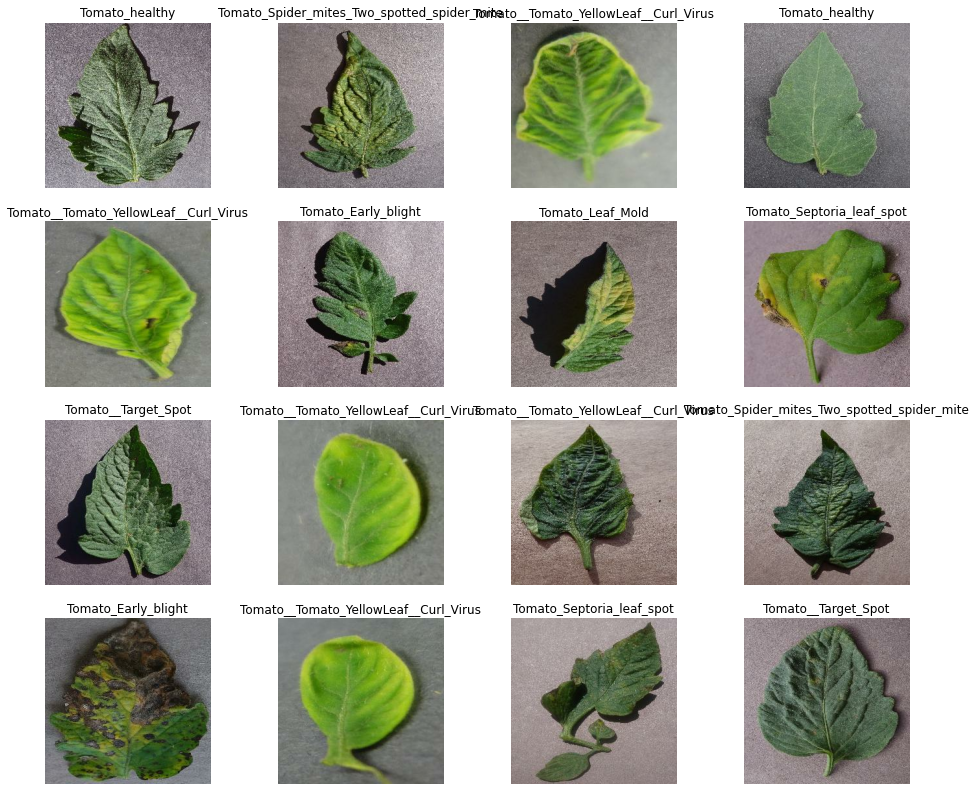

In [8]:
plt.figure(figsize = (16,14))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
def get_dataset_partitions(ds, train_split= 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(ds_size*train_split)
    
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    
    val_size = int(ds_size*val_split)
    
    val_ds = test_ds.take(val_size)
    test_ds = test_ds.skip(val_size)
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions(ds = dataset)

In [11]:
len(train_ds)

400

In [12]:
len(val_ds)

50

In [13]:
len(test_ds)

51

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                                        layers.experimental.preprocessing.Rescaling(1.0/255)])

In [16]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         layers.experimental.preprocessing.RandomRotation(0.2)])

In [17]:
len(class_names)

10

In [18]:
input_shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])



In [19]:
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [21]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
             metrics=['accuracy'])

In [24]:
history = model.fit(train_ds,
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1,
                    validation_data=val_ds)

Epoch 1/10
400/400 [==============================] - 1476s 4s/step - loss: 0.4690 - accuracy: 0.8383 - val_loss: 0.3371 - val_accuracy: 0.8725
Epoch 2/10
400/400 [==============================] - 1440s 4s/step - loss: 0.3723 - accuracy: 0.8693 - val_loss: 0.5057 - val_accuracy: 0.8269
Epoch 3/10
400/400 [==============================] - 1572s 4s/step - loss: 0.3051 - accuracy: 0.8949 - val_loss: 0.2609 - val_accuracy: 0.9106
Epoch 4/10
400/400 [==============================] - 1683s 4s/step - loss: 0.2670 - accuracy: 0.9065 - val_loss: 0.2662 - val_accuracy: 0.9087
Epoch 5/10
400/400 [==============================] - 2193s 5s/step - loss: 0.2219 - accuracy: 0.9236 - val_loss: 0.1759 - val_accuracy: 0.9312
Epoch 6/10
400/400 [==============================] - 9086s 23s/step - loss: 0.2206 - accuracy: 0.9227 - val_loss: 0.1595 - val_accuracy: 0.9463
Epoch 7/10
400/400 [==============================] - 1673s 4s/step - loss: 0.1757 - accuracy: 0.9407 - val_loss: 0.2133 - val_accuracy

In [25]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 1319s 3s/step - loss: 0.1141 - accuracy: 0.9577


In [26]:
scores

[0.11407783627510071, 0.9577205777168274]

In [27]:
history.paramss

{'verbose': 1, 'epochs': 10, 'steps': 400}

In [28]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
loss = history.history['loss']
training_accuracy = history.history['accuracy']
val_loss =  history.history['val_loss']
val_accuracy =  history.history['val_accuracy']

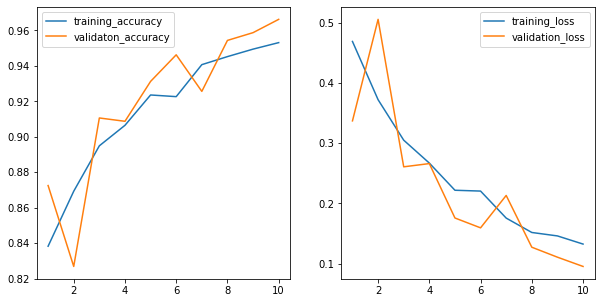

In [46]:
plt.figure(figsize = (10,5))
ax = plt.subplot(1,2,1)

plt.plot(np.arange(1,11), training_accuracy, label = 'training_accuracy')
plt.plot(np.arange(1,11), val_accuracy, label = 'validaton_accuracy')
plt.legend()


ax=plt.subplot(1,2,2)
plt.plot(np.arange(1,11), loss, label = 'training_loss')
plt.plot(np.arange(1,11), val_loss, label = 'validation_loss')
plt.legend()

first image to predict
first image's actual label: Tomato_Early_blight
predicted image label Tomato_Early_blight


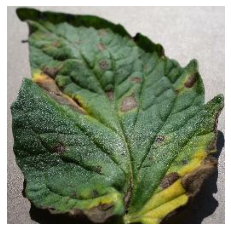

In [64]:
for image_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis('off')
    print("first image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted image label", class_names[np.argmax(batch_prediction[0])])


In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

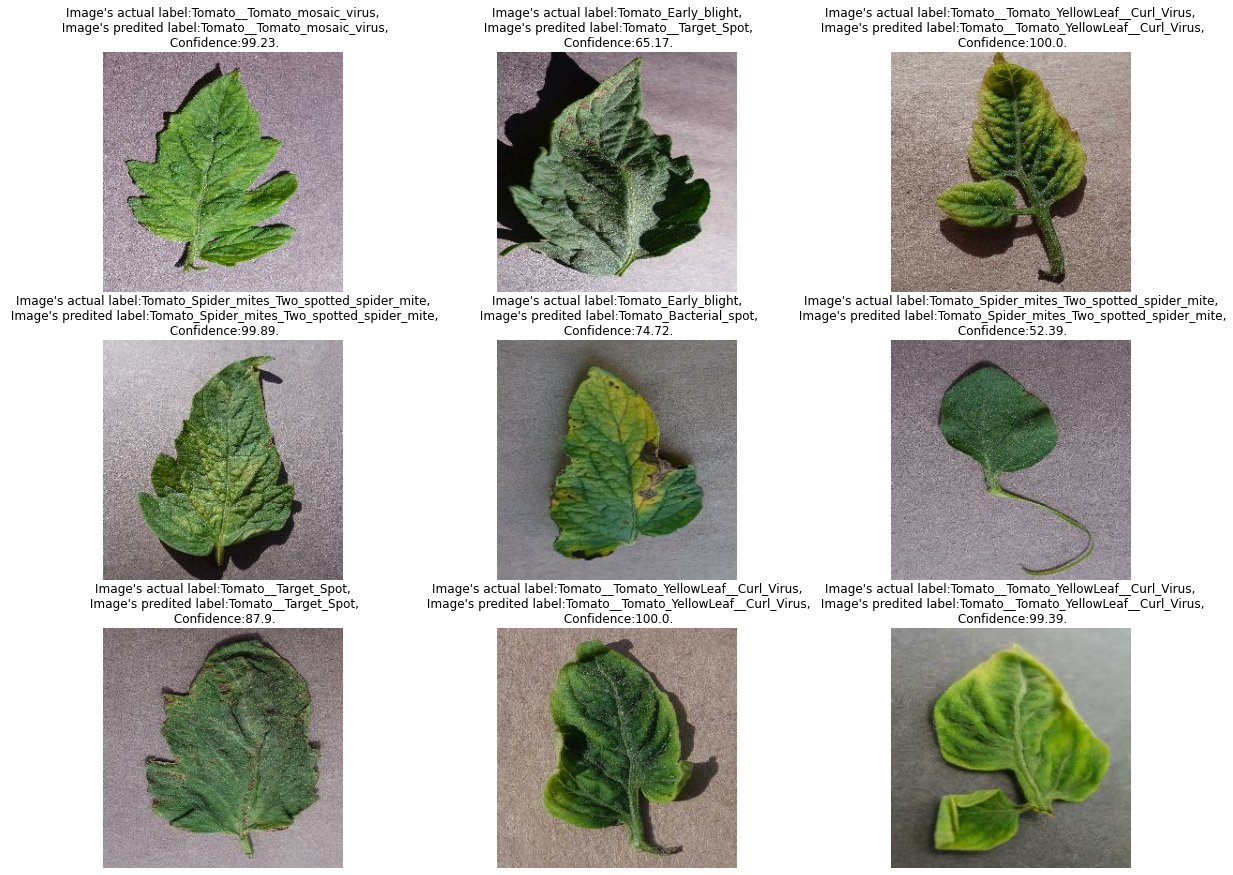

In [67]:
plt.figure(figsize = (20,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class , confidence = predict(model, images[i])
        plt.axis('off')
        plt.title(f"Image's actual label:{class_names[labels[i]]},\n Image's predited label:{predicted_class},\n Confidence:{confidence}.")

In [68]:
import os
model_version = max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
